In [16]:
import cv2
import sys
import os
import re
import torch
import datetime
import torchvision
import numpy as np
import pandas as pd
import healpy as hp
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from math import ceil
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from healpy.newvisufunc import projview, newprojplot
sys.path.append('..')
from stars import BH_stars_img
from telescope_simulator import TelescopeSimulator

libpng warning: iCCP: known incorrect sRGB profile


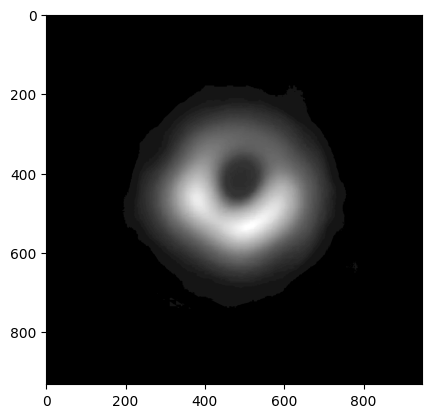

In [17]:
M87 = cv2.imread('M87_after.png', 0)
# M87_rotated = cv2.rotate(M87, cv2.ROTATE_90_CLOCKWISE)
M87_rotated = M87
plt.imshow(M87_rotated, cmap='gray')

In [18]:
angular_pixel_size_input_image = 5e-4

In [19]:
tele_config = dict(
    # physical parameters
    input_image = r"./stars/BHs.png", telescope_diameter_m = 6.5,
    telescope_focal_length_m = 131.4, angular_pixel_size_input_image = angular_pixel_size_input_image,
    wavelength = 100e-9, CCD_pixel_size = angular_pixel_size_input_image * 131.4 / 206265,
    CCD_pixel_count = 1024, show = False,
)

stars_config = dict(
    BHs_path='tele_datasets/224/', BHs=M87_rotated, num_stars=0, num_BHs=1, stars_lower_size=30, stars_upper_size=50,
    height=1024, width=1024, bg_color=0, shape='rect', BHS_lower_size=64, BH_upper_size=75
)

In [20]:
img = BH_stars_img(**stars_config)
img.stars_gen()
img.BHs_gen(rotate=False)
noise_BHs = img.add_noise(img.stars_BHs_img, radius=0)
tele_config['input_image'] = noise_BHs
telescope_simulator = TelescopeSimulator(**tele_config)
show=False
im_array = img.stars_BHs_img
intensity_image = telescope_simulator.get_intensity(im_array, show=show)
conv_image = telescope_simulator.get_convolved_image(im_array, intensity_image, show=show)
output_img = telescope_simulator.generate_image(conv_image, show=show)
# output_img = telescope_simulator.generate_image(show=False)
img_size = tele_config['CCD_pixel_count']
x, y, r, _ = img.BH_lst[0] * img_size
x, y, r = int(x), int(y), int(r)
if (x-120) >= 0 and (x + 120) < img_size and (y-120) >= 0 and (y + 120) < img_size:
    pass
else:
    if x - 120 < 0:
        x = 120
    elif x + 120 >= img_size:
        x = img_size - 120 - 1
    if y - 120 < 0:
        y = 120
    elif y + 120 >= img_size:
        y = img_size - 120 - 1
xl, xr, yl, yr = x - 120, x + 120, y - 120, y + 120
new = output_img[yl: yr, xl: xr]
cv2.imwrite('output_M87_reg.png', new)

True

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DROPOUT_RATE = 0.5

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        base = torchvision.models.efficientnet_b1(weights='EfficientNet_B1_Weights.DEFAULT')
        base.classifier[0] = nn.Dropout(p=DROPOUT_RATE, inplace=True)
        base.classifier[1] = nn.Linear(in_features=1280, out_features=256, bias=True)
        self.base = base
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=DROPOUT_RATE)
        self.fc2 = nn.Linear(in_features=256, out_features=32, bias=True)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=DROPOUT_RATE)
        self.fc3 = nn.Linear(in_features=32, out_features=1, bias=True)

    def forward(self, x):
        out = self.base(x)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc3(out)
        return out



def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer, lr):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# --------------------------------------------  Inclination ------------------------------------------------
model1 = CNN();
model1.to(device);


In [23]:
log_path = Path('../logs_recognition')

# weight_lst

In [24]:

# optimizer = optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)
# load_checkpoint(checkpoint, model1, optimizer, lr)

In [25]:
# Preprocess the image
M87 = cv2.imread('output_M87_reg.png')
weight_lst = list(log_path.rglob('*inc.pth.tar'))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = transform(M87).unsqueeze(0).to(device)
# ../logs_recognition/Inclination_PA/2024-02-21_21-34-55/models/final_PA.pth.tar

for weight in weight_lst:
    try:
        checkpoint = torch.load(weight)
    except RuntimeError:
        continue
    model1.load_state_dict(checkpoint["state_dict"])
    with torch.no_grad():
        model1.eval()
        output = model1(input_image)
    # Get the predicted value
    prediction = output.item()
    if prediction > 40:
        print(f"Prediction for M87: {prediction} with weight {weight}")
# print(f"Prediction for M87: {prediction} with weight {weight}")
# # Make the prediction
# with torch.no_grad():
#     model1.eval()
#     output = model1(input_image)

# # Get the predicted value
# prediction = output.item()

# Print the prediction
# print("Prediction for M87:", prediction)
    
# ../logs_recognition/Inclination_PA/2024-02-22_00-54-43/models/final_inc.pth.tar

Prediction for M87: 44.312744140625 with weight ../logs_recognition/Inclination_PA/2024-02-25_23-07-30/models/final_inc.pth.tar
Prediction for M87: 44.02339553833008 with weight ../logs_recognition/Inclination_PA/2024-02-25_23-07-30/models/epoch-37_MAE-30.070_inc.pth.tar
Prediction for M87: 55.8756103515625 with weight ../logs_recognition/Inclination_PA/2024-02-22_20-59-08/models/final_inc.pth.tar
Prediction for M87: 49.1949348449707 with weight ../logs_recognition/Inclination_PA/2024-02-20_23-10-57/models/final_inc.pth.tar
Prediction for M87: 46.73902893066406 with weight ../logs_recognition/Inclination_PA/2024-02-20_23-10-57/models/epoch-26_MAE-5.931_inc.pth.tar


In [26]:
# ../logs_recognition/Inclination_PA/2024-02-25_03-01-27/models/epoch-30_MAE-11.739_PA.pth.tar
# ../logs_recognition/Inclination_PA/2024-02-22_00-54-43/models/final_inc.pth.tar

In [27]:
# Preprocess the image
weight_lst = list(log_path.rglob('*PA.pth.tar'))
M87 = cv2.imread('output_M87_reg.png')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = transform(M87).unsqueeze(0).to(device)
# ../logs_recognition/Inclination_PA/2024-02-21_21-34-55/models/final_PA.pth.tar

for weight in weight_lst:
    try:
        checkpoint = torch.load(weight)
    except RuntimeError:
        continue
    model1.load_state_dict(checkpoint["state_dict"])
    with torch.no_grad():
        model1.eval()
        output = model1(input_image)
    # Get the predicted value
    prediction = output.item()
    # if (prediction < 360 and prediction > 250) or (prediction < 20 and prediction > 0):
    print(f"Prediction for M87: {prediction} with weight {weight}")
# # Make the prediction
# with torch.no_grad():
#     model1.eval()
#     output = model1(input_image)

# # Get the predicted value
# prediction = output.item()

# Print the prediction
# print("Prediction for M87:", prediction)
# ../logs_recognition/Inclination_PA/2024-02-25_09-46-01/models/final_PA.pth.tar

Prediction for M87: 3.533460855484009 with weight ../logs_recognition/Inclination_PA/2024-02-21_15-05-14/models/epoch-41_MAE-12.144_PA.pth.tar
Prediction for M87: 3.406172275543213 with weight ../logs_recognition/Inclination_PA/2024-02-21_15-05-14/models/final_PA.pth.tar
Prediction for M87: 3.5911662578582764 with weight ../logs_recognition/Inclination_PA/2024-02-23_17-22-45/models/final_PA.pth.tar
Prediction for M87: 5.354396820068359 with weight ../logs_recognition/Inclination_PA/2024-02-23_17-22-45/models/epoch-28_MAE-15.082_PA.pth.tar
Prediction for M87: -25.406137466430664 with weight ../logs_recognition/Inclination_PA/2024-02-22_10-50-05/models/epoch-37_MAE-12.233_PA.pth.tar
Prediction for M87: -25.038671493530273 with weight ../logs_recognition/Inclination_PA/2024-02-22_10-50-05/models/final_PA.pth.tar
Prediction for M87: -1.6937479972839355 with weight ../logs_recognition/Inclination_PA/2024-02-23_10-28-16/models/final_PA.pth.tar
Prediction for M87: 603.3858642578125 with weigh